<a href="https://colab.research.google.com/github/Tom-Jung/ML_Colab/blob/main/25.LSTM_predicting_Samsung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [114]:
url = 'https://raw.githubusercontent.com/neowizard2018/neowizard/master/TensorFlow2/005930.KS_3MA_5MA.csv'
raw_df = pd.read_csv(url)
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


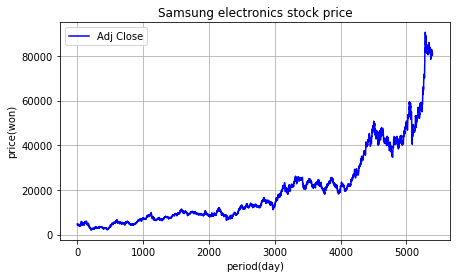

In [115]:
plt.figure(figsize=(7,4))

plt.title('Samsung electronics stock price')
plt.ylabel('price(won)')
plt.xlabel('period(day)')

plt.grid()
plt.plot(raw_df['Adj Close'], label = 'Adj Close', color='b')
plt.legend(loc='best')

plt.show()

In [116]:
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5393.000000,5391.000000
mean,22801.887178,23043.991464,22559.285582,22801.909445,19920.044863,2.207838e+07,19934.224878,19925.585966
std,17736.201238,17906.827402,17572.109940,17733.296811,17322.636387,1.564053e+07,17313.297249,17292.697383
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9880.000000,9990.000000,9800.000000,9900.000000,7726.937988,1.185265e+07,7726.939453,7709.871631
50%,15760.000000,15940.000000,15560.000000,15800.000000,12808.596680,1.803935e+07,12802.806970,12809.314840
75%,29280.000000,29560.000000,29000.000000,29280.000000,24566.556640,2.771475e+07,24558.166020,24555.269140
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [117]:
raw_df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [118]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [119]:
# Volume 값 0을 NaN으로 모두 대체(replace)

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 개수 확인
for col in raw_df.columns:
  missing_rows=raw_df.loc[raw_df[col]==0].shape[0]
  print(col +':' + str(missing_rows))


Date:0
Open:0
High:0
Low:0
Close:0
Adj Close:0
Volume:0
3MA:0
5MA:0


In [120]:
raw_df = raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [ ]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

In [122]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [123]:
# feature_df, label_df 생성

feature_cols = [ '3MA', '5MA', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [124]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5269, 3) (5269, 1)


In [125]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5229, 40, 3) (5229, 1)


In [126]:
# train, test 분리

#split = int(len(X)*0.95)
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


In [127]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [128]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               67584     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [129]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
315/315 [==============================] - 10s 28ms/step - loss: 5.1105e-04 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0264
Epoch 2/100
315/315 [==============================] - 8s 27ms/step - loss: 8.9831e-05 - mae: 0.0062 - val_loss: 6.0699e-04 - val_mae: 0.0177
Epoch 3/100
315/315 [==============================] - 9s 27ms/step - loss: 7.8242e-05 - mae: 0.0058 - val_loss: 5.7017e-04 - val_mae: 0.0189
Epoch 4/100
315/315 [==============================] - 8s 27ms/step - loss: 7.2580e-05 - mae: 0.0056 - val_loss: 5.8668e-04 - val_mae: 0.0169
Epoch 5/100
315/315 [==============================] - 10s 31ms/step - loss: 6.2199e-05 - mae: 0.0052 - val_loss: 0.0013 - val_mae: 0.0315
Epoch 6/100
315/315 [==============================] - 10s 30ms/step - loss: 5.8891e-05 - mae: 0.0051 - val_loss: 5.9129e-04 - val_mae: 0.0184
Epoch 7/100
315/315 [==============================] - 8s 26ms/step - loss: 5.9684e-05 - mae: 0.0052 - val_loss: 3.3302e-04 - val_mae: 0.0138
Epoch 8/100

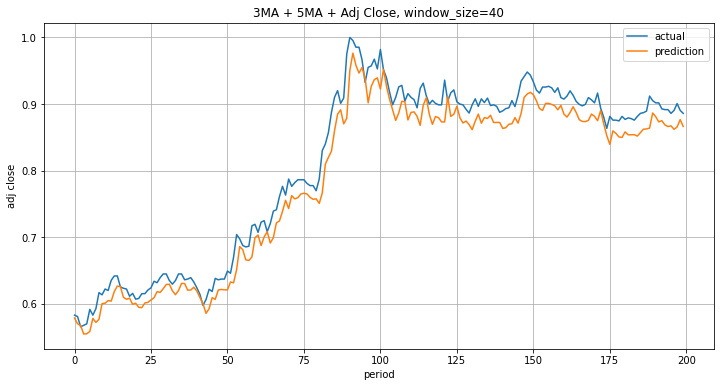

In [111]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [112]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.0288119385479862
